# Connecting Google Drive for easy access to data

##### You need to have a shortcut of the dataset folder in the "My Drive" section renamed to "HxD_dataset" (or else you need to change the name in the code to read and unzip the folder), make sure you're using the same google account for accessing **colab**

##### Make Sure you allow the third party cookies to the colab site or to overall chrome  (in setting > Privacy and Security > Third Party Cookies )

##### Run the first block and continue with your google account, and in the seconf tab make sure to select all before continuing!!

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


This access the folder and Unzip the folder to the local files in colab by creating a folder names dataset

In [3]:
import os

# 1. Define where your files are in Drive (The Shortcut)
# CHANGE 'hackfest_data' if you named the shortcut something else!
drive_folder = '/content/drive/MyDrive/HxD_dataset'

# 2. Define where you want them in Colab (Fast Local Memory)
base_dir = '/content/dataset'
os.makedirs(base_dir, exist_ok=True)

# 3. Unzip Training Data (2.6 GB)
print("⏳ Unzipping Training Data... (This is the big one)")
!unzip -q "{drive_folder}/Training.zip" -d "{base_dir}/train"
print("✅ Training data ready at: /content/dataset/train")

# 4. Unzip Test Data
print("⏳ Unzipping Test Data...")
!unzip -q "{drive_folder}/test_public_80.zip" -d "{base_dir}/test"
print("✅ Test data ready at: /content/dataset/test")

# 5. Unzip Scripts
print("⏳ Unzipping Scripts...")
!unzip -q "{drive_folder}/Scripts.zip" -d "{base_dir}/scripts"
print("✅ Scripts ready at: /content/dataset/scripts")

print("\n🎉 ALL DONE! Your data structure is ready.")

⏳ Unzipping Training Data... (This is the big one)
✅ Training data ready at: /content/dataset/train
⏳ Unzipping Test Data...
✅ Test data ready at: /content/dataset/test
⏳ Unzipping Scripts...
✅ Scripts ready at: /content/dataset/scripts

🎉 ALL DONE! Your data structure is ready.


Plot to check the Image and it's map

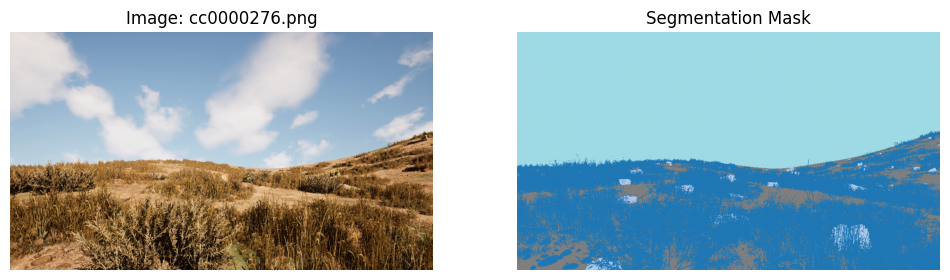

Success! Loaded cc0000276.png


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# 1. Setup Paths
root_dir = '/content/dataset/train/Offroad_Segmentation_Training_Dataset/train'
image_folder = os.path.join(root_dir, 'Color_Images')
mask_folder = os.path.join(root_dir, 'Segmentation') # <--- Fixed Path

# 2. Pick a random file to check
filenames = [f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')]
selected_file = random.choice(filenames)

img_path = os.path.join(image_folder, selected_file)
mask_path = os.path.join(mask_folder, selected_file)

# 3. Load and Plot
try:
    image = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Show Original
    ax[0].imshow(image)
    ax[0].set_title(f"Image: {selected_file}")
    ax[0].axis('off')

    # Show Segmentation Mask
    # We use 'cmap=jet' (or 'tab20') to make the classes distinct colors
    ax[1].imshow(mask, cmap='tab20')
    ax[1].set_title("Segmentation Mask")
    ax[1].axis('off')

    plt.show()
    print(f"Success! Loaded {selected_file}")

except FileNotFoundError:
    print(f"❌ Error: Could not find {selected_file} in the Segmentation folder.")
    print("Check if the mask has a different extension (e.g., .png vs .jpg)?")

✅ Training Path: /content/dataset/train/Offroad_Segmentation_Training_Dataset/train/Color_Images
✅ Test Path:     /content/dataset/test/test_public_80/Segmentation


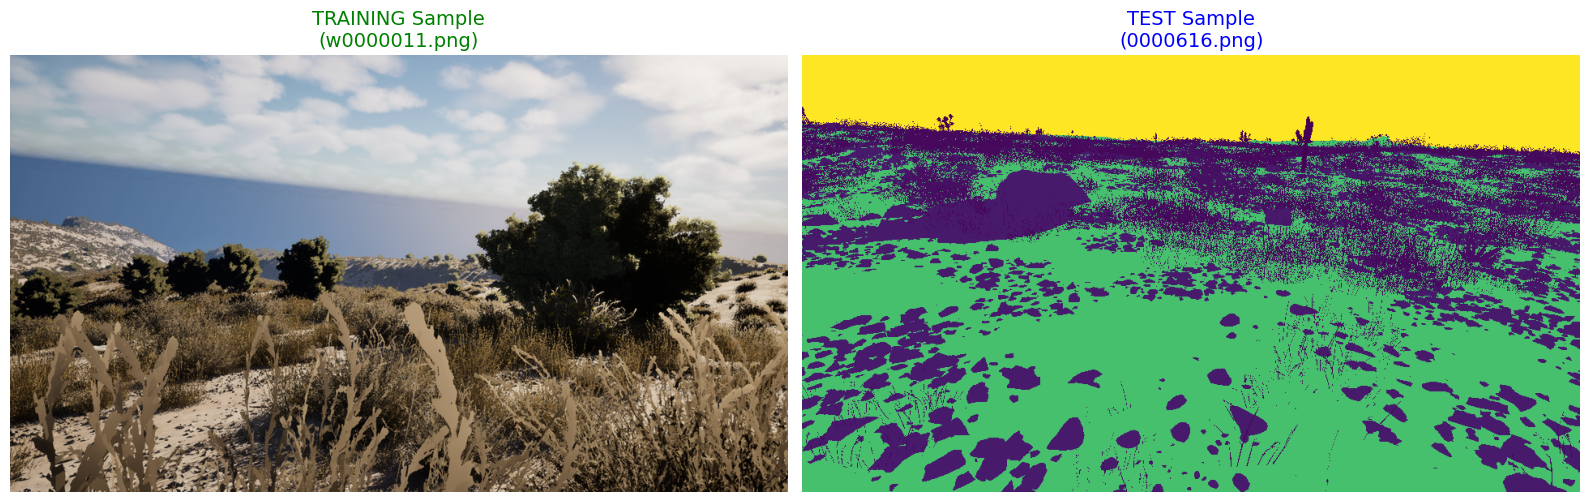

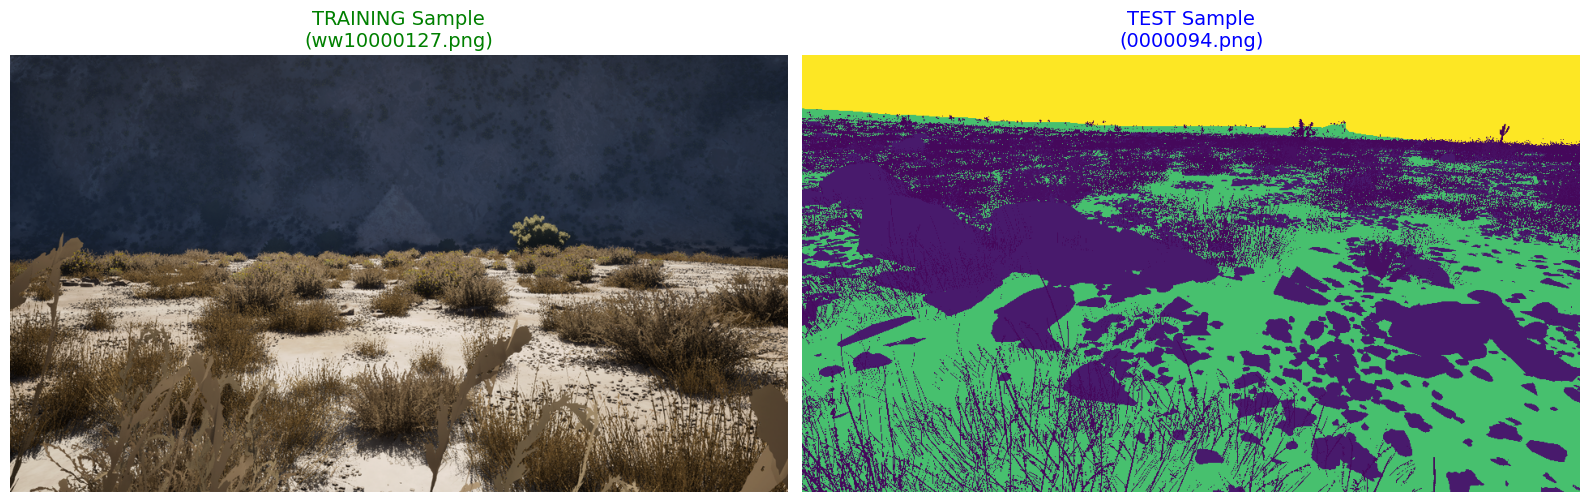

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
%matplotlib inline
# This command forces the plots to show up in the notebook again

# 1. Define Paths (Adjust based on your exact structure)
train_path = '/content/dataset/train/Offroad_Segmentation_Training_Dataset/train/Color_Images'

# Auto-find the test image folder since it might be nested
test_root = '/content/dataset/test'
test_path = None
for root, dirs, files in os.walk(test_root):
    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files):
        test_path = root
        break

if not test_path:
    print("❌ Could not find test images! Check the folder structure.")
else:
    print(f"✅ Training Path: {train_path}")
    print(f"✅ Test Path:     {test_path}")

    # 2. Pick Random Images
    train_file = random.choice(os.listdir(train_path))
    test_file = random.choice(os.listdir(test_path))

    # 3. Load Images
    train_img = Image.open(os.path.join(train_path, train_file))
    test_img = Image.open(os.path.join(test_path, test_file))

    # 4. Visualize Side-by-Side
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Training Image
    axes[0].imshow(train_img)
    axes[0].set_title(f"TRAINING Sample\n({train_file})", fontsize=14, color='green')
    axes[0].axis('off')

    # Test Image
    axes[1].imshow(test_img)
    axes[1].set_title(f"TEST Sample\n({test_file})", fontsize=14, color='blue')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Training Scripts

## Dependencies

In [4]:
pip install segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.8 MB/s eta 0:00:00


## Training Script

In [9]:
import torch
import argparse
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import cv2
import os
import torchvision
from tqdm import tqdm
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
"""
Segmentation Training Script
Converted from train_mask.ipynb
"""

# Strong Augmentations to break synthetic perfection
train_transform = A.Compose([
    A.Resize(512, 512),
    # A.Resize(height=540, width=960), # KEEP FULL RESOLUTION
    A.HorizontalFlip(p=0.5),

    # The "Dirty" Stuff (Sim-to-Real)
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
        A.MotionBlur(p=1.0),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=1.0) # Hide parts of objects
    ], p=0.5),

    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Set matplotlib to non-interactive backend
plt.switch_backend('Agg')


# ============================================================================
# Utility Functions
# ============================================================================

def save_image(img, filename):
    """Save an image tensor to file after denormalizing."""
    img = np.array(img)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = np.moveaxis(img, 0, -1)
    img = (img * std + mean) * 255
    cv2.imwrite(filename, img[:, :, ::-1])


# ============================================================================
# Mask Conversion
# ============================================================================

# Mapping from raw pixel values to new class IDs
value_map = {
    0: 0,        # background
    100: 1,      # Trees
    200: 2,      # Lush Bushes
    300: 3,      # Dry Grass
    500: 4,      # Dry Bushes
    550: 5,      # Ground Clutter
    700: 6,      # Logs
    800: 7,      # Rocks
    7100: 8,     # Landscape
    10000: 9     # Sky
}
n_classes = len(value_map)


def convert_mask(mask):
    """Convert raw mask values to class IDs."""
    arr = np.array(mask)
    new_arr = np.zeros_like(arr, dtype=np.uint8)
    for raw_value, new_value in value_map.items():
        new_arr[arr == raw_value] = new_value
    return Image.fromarray(new_arr)


# ============================================================================
# Dataset
# ============================================================================

# ============================================================================
# NEW PRO DATASET (Handles Albumentations)
# ============================================================================
class MaskDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.transform = transform
        self.data_ids = os.listdir(self.image_dir)
        # self.data_ids = sorted([
        #     f for f in os.listdir(self.image_dir)
        #     if f.endswith(('.png', '.jpg', '.jpeg'))
        # ])


    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, idx):
        data_id = self.data_ids[idx]
        img_path = os.path.join(self.image_dir, data_id)
        mask_path = os.path.join(self.masks_dir, data_id)

        # Load as Numpy Arrays (Required for Albumentations)
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = Image.open(mask_path)
        mask = np.array(convert_mask(mask)) # Convert to class IDs 0-9

        if self.transform:
            # Apply "Dirty" Augmentations to both Image and Mask
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Ensure mask is a LongTensor (int64) for the loss function
        return image, mask.long()


# ============================================================================
# Model: Segmentation Head (ConvNeXt-style)
# ============================================================================

class SegmentationHeadConvNeXt(nn.Module):
    def __init__(self, in_channels, out_channels, tokenW, tokenH):
        super().__init__()
        self.H, self.W = tokenH, tokenW

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=7, padding=3),
            nn.GELU()
        )

        self.block = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=7, padding=3, groups=128),
            nn.GELU(),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.GELU(),
        )

        self.classifier = nn.Conv2d(128, out_channels, 1)

    def forward(self, x):
        B, N, C = x.shape
        x = x.reshape(B, self.H, self.W, C).permute(0, 3, 1, 2)
        x = self.stem(x)
        x = self.block(x)
        return self.classifier(x)


# ============================================================================
# Metrics
# ============================================================================

def compute_iou(pred, target, num_classes=10, ignore_index=255):
    """Compute IoU for each class and return mean IoU."""
    pred = torch.argmax(pred, dim=1)
    pred, target = pred.view(-1), target.view(-1)

    iou_per_class = []
    for class_id in range(num_classes):
        if class_id == ignore_index:
            continue

        pred_inds = pred == class_id
        target_inds = target == class_id

        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append((intersection / union).cpu().numpy())

    return np.nanmean(iou_per_class)


def compute_dice(pred, target, num_classes=10, smooth=1e-6):
    """Compute Dice coefficient (F1 Score) per class and return mean Dice Score."""
    pred = torch.argmax(pred, dim=1)
    pred, target = pred.view(-1), target.view(-1)

    dice_per_class = []
    for class_id in range(num_classes):
        pred_inds = pred == class_id
        target_inds = target == class_id

        intersection = (pred_inds & target_inds).sum().float()
        dice_score = (2. * intersection + smooth) / (pred_inds.sum().float() + target_inds.sum().float() + smooth)

        dice_per_class.append(dice_score.cpu().numpy())

    return np.mean(dice_per_class)


def compute_pixel_accuracy(pred, target):
    """Compute pixel accuracy."""
    pred_classes = torch.argmax(pred, dim=1)
    return (pred_classes == target).float().mean().cpu().numpy()


def evaluate_metrics(model, data_loader, device, num_classes=10, show_progress=True):
    """Evaluate all metrics on a dataset."""
    iou_scores = []
    dice_scores = []
    pixel_accuracies = []

    model.eval()
    loader = tqdm(data_loader, desc="Evaluating", leave=False, unit="batch") if show_progress else data_loader

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # --- FIX: FEED IMAGE DIRECTLY TO MODEL ---
            logits = model(imgs)

            # Interpolate to match label size (just in case)
            outputs = F.interpolate(logits, size=labels.shape[1:], mode="bilinear", align_corners=False)

            labels = labels.long()

            iou = compute_iou(outputs, labels, num_classes=num_classes)
            dice = compute_dice(outputs, labels, num_classes=num_classes)
            pixel_acc = compute_pixel_accuracy(outputs, labels)

            iou_scores.append(iou)
            dice_scores.append(dice)
            pixel_accuracies.append(pixel_acc)

    model.train()
    return np.mean(iou_scores), np.mean(dice_scores), np.mean(pixel_accuracies)


# ============================================================================
# Plotting Functions
# ============================================================================

def save_training_plots(history, output_dir):
    """Save all training metric plots to files."""
    os.makedirs(output_dir, exist_ok=True)

    # Plot 1: Loss curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_pixel_acc'], label='train')
    plt.plot(history['val_pixel_acc'], label='val')
    plt.title('Pixel Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'))
    plt.close()
    print(f"Saved training curves to '{output_dir}/training_curves.png'")

    # Plot 2: IoU curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.title('Train IoU vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('Validation IoU vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'iou_curves.png'))
    plt.close()
    print(f"Saved IoU curves to '{output_dir}/iou_curves.png'")

    # Plot 3: Dice curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.title('Train Dice vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['val_dice'], label='Val Dice')
    plt.title('Validation Dice vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'dice_curves.png'))
    plt.close()
    print(f"Saved Dice curves to '{output_dir}/dice_curves.png'")

    # Plot 4: Combined metrics plot
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(history['train_iou'], label='train')
    plt.plot(history['val_iou'], label='val')
    plt.title('IoU vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(history['train_dice'], label='train')
    plt.plot(history['val_dice'], label='val')
    plt.title('Dice Score vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(history['train_pixel_acc'], label='train')
    plt.plot(history['val_pixel_acc'], label='val')
    plt.title('Pixel Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Pixel Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'all_metrics_curves.png'))
    plt.close()
    print(f"Saved combined metrics curves to '{output_dir}/all_metrics_curves.png'")


def save_history_to_file(history, output_dir):
    """Save training history to a text file."""
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, 'evaluation_metrics.txt')

    with open(filepath, 'w') as f:
        f.write("TRAINING RESULTS\n")
        f.write("=" * 50 + "\n\n")

        f.write("Final Metrics:\n")
        f.write(f"  Final Train Loss:     {history['train_loss'][-1]:.4f}\n")
        f.write(f"  Final Val Loss:       {history['val_loss'][-1]:.4f}\n")
        f.write(f"  Final Train IoU:      {history['train_iou'][-1]:.4f}\n")
        f.write(f"  Final Val IoU:        {history['val_iou'][-1]:.4f}\n")
        f.write(f"  Final Train Dice:     {history['train_dice'][-1]:.4f}\n")
        f.write(f"  Final Val Dice:       {history['val_dice'][-1]:.4f}\n")
        f.write(f"  Final Train Accuracy: {history['train_pixel_acc'][-1]:.4f}\n")
        f.write(f"  Final Val Accuracy:   {history['val_pixel_acc'][-1]:.4f}\n")
        f.write("=" * 50 + "\n\n")

        f.write("Best Results:\n")
        f.write(f"  Best Val IoU:      {max(history['val_iou']):.4f} (Epoch {np.argmax(history['val_iou']) + 1})\n")
        f.write(f"  Best Val Dice:     {max(history['val_dice']):.4f} (Epoch {np.argmax(history['val_dice']) + 1})\n")
        f.write(f"  Best Val Accuracy: {max(history['val_pixel_acc']):.4f} (Epoch {np.argmax(history['val_pixel_acc']) + 1})\n")
        f.write(f"  Lowest Val Loss:   {min(history['val_loss']):.4f} (Epoch {np.argmin(history['val_loss']) + 1})\n")
        f.write("=" * 50 + "\n\n")

        f.write("Per-Epoch History:\n")
        f.write("-" * 100 + "\n")
        headers = ['Epoch', 'Train Loss', 'Val Loss', 'Train IoU', 'Val IoU',
                   'Train Dice', 'Val Dice', 'Train Acc', 'Val Acc']
        f.write("{:<8} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}\n".format(*headers))
        f.write("-" * 100 + "\n")

        n_epochs = len(history['train_loss'])
        for i in range(n_epochs):
            f.write("{:<8} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}\n".format(
                i + 1,
                history['train_loss'][i],
                history['val_loss'][i],
                history['train_iou'][i],
                history['val_iou'][i],
                history['train_dice'][i],
                history['val_dice'][i],
                history['train_pixel_acc'][i],
                history['val_pixel_acc'][i]
            ))

    print(f"Saved evaluation metrics to {filepath}")


# ============================================================================
# Main Training Function
# ============================================================================

def main():
    # -------------------------------------------------------
    # 1. SETUP & CONFIGURATION
    # -------------------------------------------------------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size = 4
    lr = 1e-4
    n_epochs = 30

    # Directories
    script_dir = '/content/dataset/training_output'
    output_dir = os.path.join(script_dir, 'train_stats')
    os.makedirs(output_dir, exist_ok=True)

    data_dir = '/content/dataset/train/Offroad_Segmentation_Training_Dataset/train'
    val_dir = '/content/dataset/train/Offroad_Segmentation_Training_Dataset/val'

    # -------------------------------------------------------
    # 2. FIXED AUGMENTATIONS
    # -------------------------------------------------------
    train_transform = A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),

        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            A.MotionBlur(blur_limit=5, p=1.0),
            A.CoarseDropout(
                num_holes_range=(1, 8),
                hole_height_range=(8, 32),
                hole_width_range=(8, 32),
                fill_value=0,
                p=1.0
            )
        ], p=0.8),

        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    # -------------------------------------------------------
    # 3. DATASETS & LOADERS
    # -------------------------------------------------------
    trainset = MaskDataset(data_dir=data_dir, transform=train_transform)
    valset = MaskDataset(data_dir=val_dir, transform=val_transform)

    train_loader = DataLoader(
        trainset,
        batch_size=8,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        valset,
        batch_size=8,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"Training samples: {len(trainset)}")
    print(f"Validation samples: {len(valset)}")

    # -------------------------------------------------------
    # 4. MODEL LOADING
    # -------------------------------------------------------
    print("Loading U-Net (ResNet34)...")
    classifier = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=n_classes
    )
    classifier = classifier.to(device)

    # Optimizer & Loss
    dice_loss = smp.losses.DiceLoss(mode='multiclass')
    focal_loss = smp.losses.FocalLoss(mode='multiclass', gamma=2.0)
    optimizer = optim.Adam(classifier.parameters(), lr=lr)

    # Mixed Precision Scaler
    scaler = torch.cuda.amp.GradScaler()

    # History Tracking
    history = {k: [] for k in ['train_loss', 'val_loss', 'train_iou', 'val_iou',
                               'train_dice', 'val_dice', 'train_pixel_acc', 'val_pixel_acc']}

    # -------------------------------------------------------
    # 5. TRAINING LOOP
    # -------------------------------------------------------
    print("\nStarting PRO training (T4 Mixed Precision)...")
    print("=" * 80)

    for epoch in range(n_epochs):
        classifier.train()
        train_losses = []

        # Progress bar
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]", leave=False)

        for imgs, labels in train_pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            # --- MIXED PRECISION FORWARD PASS ---
            with torch.cuda.amp.autocast():
                outputs = classifier(imgs)
                labels = labels.long()
                loss = dice_loss(outputs, labels) + focal_loss(outputs, labels)

            # --- BACKWARD PASS ---
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())
            train_pbar.set_postfix(loss=f"{loss.item():.4f}")

        # --- VALIDATION LOOP ---
        classifier.eval()
        val_losses = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = classifier(imgs)
                labels = labels.long()
                loss = dice_loss(outputs, labels) + focal_loss(outputs, labels)
                val_losses.append(loss.item())

        # --- METRICS CALCULATION ---
        # NOTE: Skipping training metrics to save time, but passing 0.0 to prevent CRASH
        train_iou, train_dice, train_pixel_acc = 0.0, 0.0, 0.0

        val_iou, val_dice, val_pixel_acc = evaluate_metrics(
            classifier, val_loader, device, num_classes=n_classes, show_progress=False
        )

        # Store history
        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)

        # --- FIX: UNCOMMENTED THESE SO THE SAVE FUNCTION WORKS ---
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_iou'].append(train_iou) # Appending 0.0
        history['val_iou'].append(val_iou)
        history['train_dice'].append(train_dice) # Appending 0.0
        history['val_dice'].append(val_dice)
        history['train_pixel_acc'].append(train_pixel_acc) # Appending 0.0
        history['val_pixel_acc'].append(val_pixel_acc)

        print(f"Epoch {epoch+1} Results: Loss: {epoch_train_loss:.4f} | Val IoU: {val_iou:.4f} | Val Acc: {val_pixel_acc:.4f}")

    # -------------------------------------------------------
    # 6. SAVE RESULTS
    # -------------------------------------------------------
    print("\nSaving results...")
    save_training_plots(history, output_dir)
    save_history_to_file(history, output_dir)

    model_path = os.path.join(script_dir, "segmentation_head.pth")
    torch.save(classifier.state_dict(), model_path)
    print(f"Saved model to '{model_path}'")

if __name__ == "__main__":
    main()

/tmp/ipython-input-3085412603.py:32: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
/tmp/ipython-input-3085412603.py:34: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=1.0) # Hide parts of objects
/tmp/ipython-input-3085412603.py:457: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
/tmp/ipython-input-3085412603.py:459: UserWarning: Argument(s) 'fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


Using device: cuda
Training samples: 2857
Validation samples: 317
Loading U-Net (ResNet34)...


/tmp/ipython-input-3085412603.py:522: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Starting PRO training (T4 Mixed Precision)...


Epoch 1/30 [Train]:   0%|          | 0/358 [00:00<?, ?it/s]/tmp/ipython-input-3085412603.py:547: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 Results: Loss: 1.7614 | Val IoU: 0.2386 | Val Acc: 0.7527


Epoch 2 Results: Loss: 1.0933 | Val IoU: 0.3561 | Val Acc: 0.8177


Epoch 3 Results: Loss: 0.9409 | Val IoU: 0.4348 | Val Acc: 0.8366


Epoch 4 Results: Loss: 0.8582 | Val IoU: 0.4845 | Val Acc: 0.8471


Epoch 5 Results: Loss: 0.8026 | Val IoU: 0.5111 | Val Acc: 0.8506


Epoch 6 Results: Loss: 0.7555 | Val IoU: 0.5232 | Val Acc: 0.8522


Epoch 7 Results: Loss: 0.7309 | Val IoU: 0.5414 | Val Acc: 0.8586


Epoch 8 Results: Loss: 0.7086 | Val IoU: 0.5479 | Val Acc: 0.8587


Epoch 9 Results: Loss: 0.6868 | Val IoU: 0.5527 | Val Acc: 0.8618


Epoch 10 Results: Loss: 0.6762 | Val IoU: 0.5546 | Val Acc: 0.8610


Epoch 11 Results: Loss: 0.6691 | Val IoU: 0.5812 | Val Acc: 0.8636


Epoch 12 Results: Loss: 0.6495 | Val IoU: 0.5950 | Val Acc: 0.8653


Epoch 13 Results: Loss: 0.6326 | Val IoU: 0.6061 | Val Acc: 0.8660


Epoch 14 Results: Loss: 0.6031 | Val IoU: 0.6053 | Val Acc: 0.8663


Epoch 15 Results: Loss: 0.5923 | Val IoU: 0.6099 | Val Acc: 0.8685


Epoch 16 Results: Loss: 0.5927 | Val IoU: 0.6147 | Val Acc: 0.8662


Epoch 17 Results: Loss: 0.5845 | Val IoU: 0.6151 | Val Acc: 0.8663


Epoch 18 Results: Loss: 0.5761 | Val IoU: 0.6206 | Val Acc: 0.8699


Epoch 19 Results: Loss: 0.5761 | Val IoU: 0.6196 | Val Acc: 0.8683


Epoch 20 Results: Loss: 0.5806 | Val IoU: 0.6239 | Val Acc: 0.8702


Epoch 21 Results: Loss: 0.5587 | Val IoU: 0.6235 | Val Acc: 0.8702


Epoch 22 Results: Loss: 0.5539 | Val IoU: 0.6283 | Val Acc: 0.8726


Epoch 23 Results: Loss: 0.5520 | Val IoU: 0.6228 | Val Acc: 0.8726


Epoch 24 Results: Loss: 0.5499 | Val IoU: 0.6297 | Val Acc: 0.8730


Epoch 25 Results: Loss: 0.5449 | Val IoU: 0.6295 | Val Acc: 0.8727


Epoch 26 Results: Loss: 0.5410 | Val IoU: 0.6322 | Val Acc: 0.8734


Epoch 27 Results: Loss: 0.5409 | Val IoU: 0.6287 | Val Acc: 0.8725


Epoch 28 Results: Loss: 0.5381 | Val IoU: 0.6360 | Val Acc: 0.8741


Epoch 29 Results: Loss: 0.5360 | Val IoU: 0.6335 | Val Acc: 0.8729


Epoch 30 Results: Loss: 0.5346 | Val IoU: 0.6364 | Val Acc: 0.8756

Saving results...
Saved training curves to '/content/dataset/training_output/train_stats/training_curves.png'
Saved IoU curves to '/content/dataset/training_output/train_stats/iou_curves.png'
Saved Dice curves to '/content/dataset/training_output/train_stats/dice_curves.png'
Saved combined metrics curves to '/content/dataset/training_output/train_stats/all_metrics_curves.png'
Saved evaluation metrics to /content/dataset/training_output/train_stats/evaluation_metrics.txt
Saved model to '/content/dataset/training_output/segmentation_head.pth'


# Testing

In [ ]:
import argparse
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import segmentation_models_pytorch as smp

# ----------------------------
# 1. ADD THE MAPPING (Copy from Training)
# ----------------------------
value_map = {
    0: 0,        # background
    100: 1,      # Trees
    200: 2,      # Lush Bushes
    300: 3,      # Dry Grass
    500: 4,      # Dry Bushes
    550: 5,      # Ground Clutter
    700: 6,      # Logs
    800: 7,      # Rocks
    7100: 8,     # Landscape
    10000: 9     # Sky
}

def convert_mask(mask_pil):
    """Convert raw mask values (0, 100, 200...) to Class IDs (0, 1, 2...)"""
    arr = np.array(mask_pil)
    new_arr = np.zeros_like(arr, dtype=np.uint8)
    for raw_value, new_value in value_map.items():
        new_arr[arr == raw_value] = new_value
    return torch.from_numpy(new_arr).long()

# ----------------------------
# 2. UPDATED DATASET CLASS
# ----------------------------
class SegmentationTestDataset(Dataset):
    def __init__(self, root_dir, img_size=512):
        self.images_dir = os.path.join(root_dir, "Color_Images")
        self.masks_dir = os.path.join(root_dir, "Segmentation")

        self.image_files = sorted(os.listdir(self.images_dir))
        self.has_masks = os.path.exists(self.masks_dir)

        # FIX: MATCH TRAINING NORMALIZATION (Mean/Std)
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Masks need Nearest Neighbor resize to preserve values (not Bilinear!)
        self.mask_resize = transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if self.has_masks:
            mask_path = os.path.join(self.masks_dir, img_name)
            if os.path.exists(mask_path):
                mask = Image.open(mask_path)

                # Resize FIRST
                mask = self.mask_resize(mask)

                # THEN Convert raw values (100, 200) -> IDs (1, 2)
                mask = convert_mask(mask)
            else:
                mask = torch.zeros((image.shape[1], image.shape[2]), dtype=torch.long)
        else:
            mask = torch.zeros((image.shape[1], image.shape[2]), dtype=torch.long)

        return image, mask, img_name

# ==========================================
# 2. MAIN EXECUTION
# ==========================================
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_dir", type=str, required=True)
    parser.add_argument("--model_path", type=str, required=True)
    parser.add_argument("--output_dir", type=str, default="predictions")
    parser.add_argument("--batch_size", type=int, default=4)
    parser.add_argument("--img_size", type=int, default=512)
    parser.add_argument("--num_classes", type=int, default=10)

    # --- ARGS CONFIGURATION (UPDATED FOR YOUR PATH) ---
    args = parser.parse_args([
        '--data_dir', '/content/dataset/test/test_public_80',      # <--- YOUR CORRECT PATH
        '--model_path', '/content/dataset/training_output/segmentation_head.pth',
        '--output_dir', '/content/inference_results',
        '--batch_size', '8',
        '--img_size', '512'
    ])
    # --------------------------------------------------

    os.makedirs(args.output_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load Dataset
    print(f"Looking for data in: {args.data_dir}")
    dataset = SegmentationTestDataset(args.data_dir, img_size=args.img_size)
    print(f"Found {len(dataset)} images.")

    if len(dataset) == 0:
        print("❌ Error: No images found. Check path again.")
        return

    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)

    # Load Model
    print("Loading U-Net ResNet34...")
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=args.num_classes)

    try:
        model.load_state_dict(torch.load(args.model_path, map_location=device))
    except:
        model = torch.load(args.model_path, map_location=device)

    model = model.to(device)
    model.eval()
    print("Model loaded successfully!")

    # --- METRICS INITIALIZATION ---
    total_intersection = np.zeros(args.num_classes)
    total_union = np.zeros(args.num_classes)

    class_names = [
        "Background", "Trees", "Lush Bushes", "Dry Grass", "Dry Bushes",
        "Ground Clutter", "Logs", "Rocks", "Landscape", "Sky"
    ]

    palette = np.array([
        [0, 0, 0], [34, 139, 34], [0, 255, 0], [210, 180, 140], [139, 90, 43],
        [128, 128, 0], [139, 69, 19], [128, 128, 128], [160, 82, 45], [135, 206, 235]
    ], dtype=np.uint8)

    print(f"Starting inference...")

    with torch.no_grad():
        for images, true_masks, names in tqdm(dataloader):
            images = images.to(device)
            true_masks = true_masks.numpy()

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            # --- CALCULATE METRICS ---
            for i in range(args.num_classes):
                pred_inds = (preds == i)
                target_inds = (true_masks == i)
                intersection = (pred_inds & target_inds).sum()
                union = (pred_inds | target_inds).sum()

                total_intersection[i] += intersection
                total_union[i] += union

            # --- SAVE IMAGES ---
            for i in range(len(preds)):
                mask = preds[i].astype(np.uint8)
                img_name = names[i]

                # Save Color Vis
                h, w = mask.shape
                color_mask = np.zeros((h, w, 3), dtype=np.uint8)
                for class_id, color in enumerate(palette):
                    color_mask[mask == class_id] = color
                Image.fromarray(color_mask).save(os.path.join(args.output_dir, f"vis_{img_name}"))

    # --- FINAL REPORT ---
    iou_per_class = total_intersection / (total_union + 1e-6)
    mean_iou = np.mean(iou_per_class)

    print("\n" + "="*40)
    print(f"FINAL TEST RESULTS (mIoU: {mean_iou:.4f})")
    print("="*40)
    print(f"{'Class Name':<20} | {'IoU':<10}")
    print("-" * 35)

    for i, name in enumerate(class_names):
        print(f"{name:<20} | {iou_per_class[i]:.4f}")
    print("-" * 35)
    print(f"MEAN IoU             | {mean_iou:.4f}")
    print("="*40)

if __name__ == "__main__":
    main()

Using device: cpu
Looking for data in: /content/dataset/test/test_public_80
Found 801 images.
Loading U-Net ResNet34...
Model loaded successfully!
Starting inference...


  0%|          | 0/101 [00:00<?, ?it/s]